## Investigating how presence of diabetes impacts CVD risk (Framingham Score)

>The plan here is to run a regression using matching, that will help to determine the impact of having diabetes on continuous CVD risk, as described by the Framingham Risk Score. First, we will run a normal regression to show what the results are without controlling for other variables. We will then look at the impact of how matching with DAME changes these results. We will also look at the impact of age and diabetes on CVD risk.

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf

df = pd.read_csv(
    "/Users/lilahduboff/Documents/Duke_Unifying_DataScience/UDS_Final_Proj/UDS_CVD_Final_Project_Rep/bangladesh_data.csv"
)
df.head()

,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),...,Physical Activity Level,Family History of CVD,CVD Risk Level,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
0,F,32.0,69.1,1.71,23.6,86.2,125/79,248.0,78.0,111.0,...,Low,N,INTERMEDIARY,171.0,0.504,125.0,79.0,Elevated,140.0,17.93
1,F,55.0,118.7,1.69,41.6,82.5,139/70,162.0,50.0,135.0,...,High,Y,HIGH,169.0,0.488,139.0,70.0,Hypertension Stage 1,82.0,20.51
2,M,NaN,NaN,1.83,26.9,106.7,104/77,103.0,73.0,114.0,...,High,Y,INTERMEDIARY,183.0,0.583,104.0,77.0,Normal,0.0,12.64
3,M,44.0,108.3,1.80,33.4,96.6,140/83,134.0,46.0,91.0,...,High,Y,INTERMEDIARY,NaN,0.537,140.0,83.0,Hypertension Stage 1,58.0,16.36
4,F,32.0,99.5,1.86,28.8,102.7,144/83,146.0,64.0,141.0,...,High,N,INTERMEDIARY,186.0,0.552,144.0,83.0,Hypertension Stage 1,52.0,17.88


> First, we're going to impute the numerical columns with missing data with the mean of the variables. This seemed like the most feasible decision because...

In [109]:
# Impute missing values
df["Age"].fillna(df["Age"].mean(), inplace=True)

df["BMI"].fillna(df["BMI"].mean(), inplace=True)

df["Total Cholesterol (mg/dL)"].fillna(
    df["Total Cholesterol (mg/dL)"].mean(), inplace=True
)

df["HDL (mg/dL)"].fillna(df["HDL (mg/dL)"].mean(), inplace=True)

df["Fasting Blood Sugar (mg/dL)"].fillna(
    df["Fasting Blood Sugar (mg/dL)"].mean(), inplace=True
)

df["Systolic BP"].fillna(df["Systolic BP"].mean(), inplace=True)

df["Diastolic BP"].fillna(df["Diastolic BP"].mean(), inplace=True)

df["Estimated LDL (mg/dL)"].fillna(df["Estimated LDL (mg/dL)"].mean(), inplace=True)

df.isnull().sum()

Sex                              0
Age                              0
Weight (kg)                     81
Height (m)                      67
BMI                              0
Abdominal Circumference (cm)    67
Blood Pressure (mmHg)            0
Total Cholesterol (mg/dL)        0
HDL (mg/dL)                      0
Fasting Blood Sugar (mg/dL)      0
Smoking Status                   0
Diabetes Status                  0
Physical Activity Level          0
Family History of CVD            0
CVD Risk Level                   0
Height (cm)                     74
Waist-to-Height Ratio           79
Systolic BP                      0
Diastolic BP                     0
Blood Pressure Category          0
Estimated LDL (mg/dL)            0
CVD Risk Score                  70
dtype: int64

>Ok there's still quite a few rows with missing data. Let's drop the columns we don't need (given the CDC's list of risk factors) and see if that changes anything. We'll be dropping: CVD risk score because it's a leveled version (low, med, high), and would skew results; Blood Pressure (mmHg) because we already have systolic and diastolic, and there's no simple way to convert blood pressure to a decimal/float; Waist-to-Height Ratio and Abdomical Circumference (cm) because they're not entirely relevant to what we're looking at; height and weight variables because we already have BMI, which takes both of those into account, and provides a more succinct way to measure physical stature. 

In [110]:
# we're going to drop BP (mmHg) as well, because it's a combination of systolic and diastolic
df = df.drop(
    columns=[
        "CVD Risk Level",
        "Blood Pressure (mmHg)",
        "Waist-to-Height Ratio",
        "CVD Risk Level",
        "Abdominal Circumference (cm)",
        "Height (m)",
        "Weight (kg)",
        "Height (cm)",
    ],
    errors="ignore",
)

df.head()

,Sex,Age,BMI,Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
0,F,32.0000,23.6,248.0,78.0,111.0,N,Y,Low,N,125.0,79.0,Elevated,140.0,17.93
1,F,55.0000,41.6,162.0,50.0,135.0,Y,Y,High,Y,139.0,70.0,Hypertension Stage 1,82.0,20.51
2,M,47.0255,26.9,103.0,73.0,114.0,N,N,High,Y,104.0,77.0,Normal,0.0,12.64
3,M,44.0000,33.4,134.0,46.0,91.0,N,N,High,Y,140.0,83.0,Hypertension Stage 1,58.0,16.36
4,F,32.0000,28.8,146.0,64.0,141.0,Y,Y,High,N,144.0,83.0,Hypertension Stage 1,52.0,17.88


### Recoding guide

Now we need to recode the Yes/No variables to binary to make it easier to model. 

- Sex: 1 for female, 0 for male
- Smoking Status: 1 for yes, 0 for no
- Diabetes Status: 1 for yes, 0 for no
- Physical Activity Level: 0 for low, 1 for moderate, 2 for high
- CVD Risk Level: 1 for intermediary or high risk, 0 for low to no risk
- Blood Pressure Category: 0 for normal; 1 for elevated; 2 for hypertension stage one; and 3 for hypertension stage two
- Family history of CVD: 0 for no; 1 for yes

In [111]:
# Recoding Sex
df["Sex"] = df["Sex"].replace({"F": 1, "M": 0})

# Recoding Smoking Status
df["Smoking Status"] = df["Smoking Status"].replace({"Y": 1, "N": 0})

# Recoding Diabetes Status
df["Diabetes Status"] = df["Diabetes Status"].replace({"Y": 1, "N": 0})

# Recoding Physical Activity Level
df["Physical Activity Level"] = df["Physical Activity Level"].replace(
    {"Low": 0, "Moderate": 1, "High": 2}
)

# Recoding Blood Pressure Category
df["Blood Pressure Category"] = df["Blood Pressure Category"].replace(
    {"Normal": 0, "Elevated": 1, "Hypertension Stage 1": 2, "Hypertension Stage 2": 3}
)

# Recoding Family History of CVD
df["Family History of CVD"] = df["Family History of CVD"].replace({"Y": 1, "N": 0})

In [112]:
df.head()

,Sex,Age,BMI,Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
0,1,32.0000,23.6,248.0,78.0,111.0,0,1,0,0,125.0,79.0,1,140.0,17.93
1,1,55.0000,41.6,162.0,50.0,135.0,1,1,2,1,139.0,70.0,2,82.0,20.51
2,0,47.0255,26.9,103.0,73.0,114.0,0,0,2,1,104.0,77.0,0,0.0,12.64
3,0,44.0000,33.4,134.0,46.0,91.0,0,0,2,1,140.0,83.0,2,58.0,16.36
4,1,32.0000,28.8,146.0,64.0,141.0,1,1,2,0,144.0,83.0,2,52.0,17.88


In [113]:
has_diabetes = df[df["Diabetes Status"] == 1]
no_diabetes = df[df["Diabetes Status"] == 0]


def print_means(df, label):
    print(f"\nMeans for {label}:")
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            print(f"{col}: {df[col].mean():.2f}")


print_means(has_diabetes, "People with Diabetes")
print_means(no_diabetes, "People without Diabetes")


Means for People with Diabetes:
Sex: 0.51
Age: 46.79
BMI: 28.87
Total Cholesterol (mg/dL): 199.35
HDL (mg/dL): 55.61
Fasting Blood Sugar (mg/dL): 117.80
Smoking Status: 0.51
Diabetes Status: 1.00
Physical Activity Level: 1.04
Family History of CVD: 0.50
Systolic BP: 125.29
Diastolic BP: 82.97
Blood Pressure Category: 1.95
Estimated LDL (mg/dL): 113.06
CVD Risk Score: 18.05

Means for People without Diabetes:
Sex: 0.50
Age: 47.27
BMI: 28.05
Total Cholesterol (mg/dL): 197.71
HDL (mg/dL): 56.81
Fasting Blood Sugar (mg/dL): 117.16
Smoking Status: 0.52
Diabetes Status: 0.00
Physical Activity Level: 0.99
Family History of CVD: 0.48
Systolic BP: 125.98
Diastolic BP: 82.86
Blood Pressure Category: 1.96
Estimated LDL (mg/dL): 109.99
CVD Risk Score: 15.85


>While looking at the numerical columns, it actually seems like most of the variables are pretty equal for the two groups. The few I may check are Estimated LDL, and Physical Activity Level. Ones that seem ok but could check regardless are Age, and Total Cholesterol. CVD risk score has an obvious difference as well, but as this is our outcome variable, I want to run more tests without definitively stating that the two groups are different in their CVD risk.

In [114]:
diabetes_ldl = df[df["Diabetes Status"] == 1]["Estimated LDL (mg/dL)"]
no_diabetes_ldl = df[df["Diabetes Status"] == 0]["Estimated LDL (mg/dL)"]

t_stat, p_value = stats.ttest_ind(diabetes_ldl, no_diabetes_ldl)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

T-statistic: 1.0434
P-value: 0.2969


In [115]:
diabetes_phys_act = df[df["Diabetes Status"] == 1]["Physical Activity Level"]
no_diabetes_phys_act = df[df["Diabetes Status"] == 0]["Physical Activity Level"]

t_stat, p_value = stats.ttest_ind(diabetes_phys_act, no_diabetes_phys_act)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

T-statistic: 1.3359
P-value: 0.1818


>Ok great, these ones had the largest differences and they are not significant! Now let's check the group counts with a contingency table

In [116]:
# Crosstab by sex
pd.crosstab(df["Diabetes Status"], df["Sex"], margins=True)

Sex,0,1,All
Diabetes Status,,,
0,374,378,752
1,382,395,777
All,756,773,1529


In [117]:
# crosstab by smoking status
pd.crosstab(df["Diabetes Status"], df["Smoking Status"], margins=True)

Smoking Status,0,1,All
Diabetes Status,,,
0,362,390,752
1,378,399,777
All,740,789,1529


In [118]:
# crosstab by family history of CVD
pd.crosstab(df["Diabetes Status"], df["Family History of CVD"], margins=True)

Family History of CVD,0,1,All
Diabetes Status,,,
0,392,360,752
1,388,389,777
All,780,749,1529


>Ok these look great! Let's check null values since I remembered that there were still some missing in the risk column:

In [119]:
df.isnull().sum()

Sex                             0
Age                             0
BMI                             0
Total Cholesterol (mg/dL)       0
HDL (mg/dL)                     0
Fasting Blood Sugar (mg/dL)     0
Smoking Status                  0
Diabetes Status                 0
Physical Activity Level         0
Family History of CVD           0
Systolic BP                     0
Diastolic BP                    0
Blood Pressure Category         0
Estimated LDL (mg/dL)           0
CVD Risk Score                 70
dtype: int64

>Unfortunately, I don't see much of a way around imputing risk without heavy analysis. @Nick if you see this, is there anything we could try besides completely dropping them, as I will do now?

In [120]:
df["CVD Risk Score"].isnull().dropna()

df.isnull().sum()

Sex                             0
Age                             0
BMI                             0
Total Cholesterol (mg/dL)       0
HDL (mg/dL)                     0
Fasting Blood Sugar (mg/dL)     0
Smoking Status                  0
Diabetes Status                 0
Physical Activity Level         0
Family History of CVD           0
Systolic BP                     0
Diastolic BP                    0
Blood Pressure Category         0
Estimated LDL (mg/dL)           0
CVD Risk Score                 70
dtype: int64

In [121]:
df = df.dropna(subset=["CVD Risk Score"])

df.isnull().sum()

Sex                            0
Age                            0
BMI                            0
Total Cholesterol (mg/dL)      0
HDL (mg/dL)                    0
Fasting Blood Sugar (mg/dL)    0
Smoking Status                 0
Diabetes Status                0
Physical Activity Level        0
Family History of CVD          0
Systolic BP                    0
Diastolic BP                   0
Blood Pressure Category        0
Estimated LDL (mg/dL)          0
CVD Risk Score                 0
dtype: int64

### Regular Linear Regression


Model Evaluation:
Mean Squared Error: 0.15
R-squared: 0.98


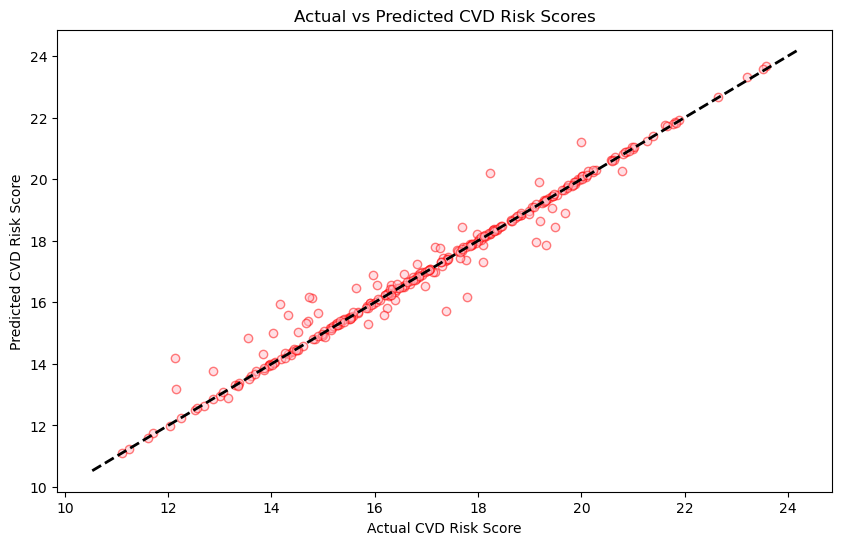


Feature Coefficients:
                        Feature  Coefficient
7               Diabetes Status     2.003248
2                           BMI     0.200423
10                  Systolic BP     0.049205
12      Blood Pressure Category     0.025866
3     Total Cholesterol (mg/dL)     0.011386
13        Estimated LDL (mg/dL)     0.009058
4                   HDL (mg/dL)     0.008657
9         Family History of CVD     0.008574
8       Physical Activity Level     0.007836
5   Fasting Blood Sugar (mg/dL)     0.000082
1                           Age    -0.000070
11                 Diastolic BP    -0.000740
0                           Sex    -0.015992
6                Smoking Status    -0.033412


In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target
X = df.drop("CVD Risk Score", axis=1)
y = df["CVD Risk Score"]

# splitting into train and test, will add validation later
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# initializing the linear model
model = LinearRegression()
model.fit(X_train, y_train)

# predictions on the test set
y_pred = model.predict(X_test)

# assessing model fit and accuracy
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# plotting linear regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="pink", edgecolors="red")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=2)
plt.xlabel("Actual CVD Risk Score")
plt.ylabel("Predicted CVD Risk Score")
plt.title("Actual vs Predicted CVD Risk Scores")
plt.show()

# coeffs
coefficients = pd.DataFrame(
    {"Feature": X.columns, "Coefficient": model.coef_}
).sort_values(by="Coefficient", ascending=False)

print("\nFeature Coefficients:")
print(coefficients)

In [134]:
from scipy.stats import linregress

df_clean = df[["Age", "CVD Risk Score"]].dropna()

slope, intercept, r_value, p_value, std_err = linregress(
    df_clean["Age"], df_clean["CVD Risk Score"]
)

r_squared = r_value**2
print(f"R-squared: {r_squared:.4f}")

print(std_err)

R-squared: 0.0028
0.005286868745631928


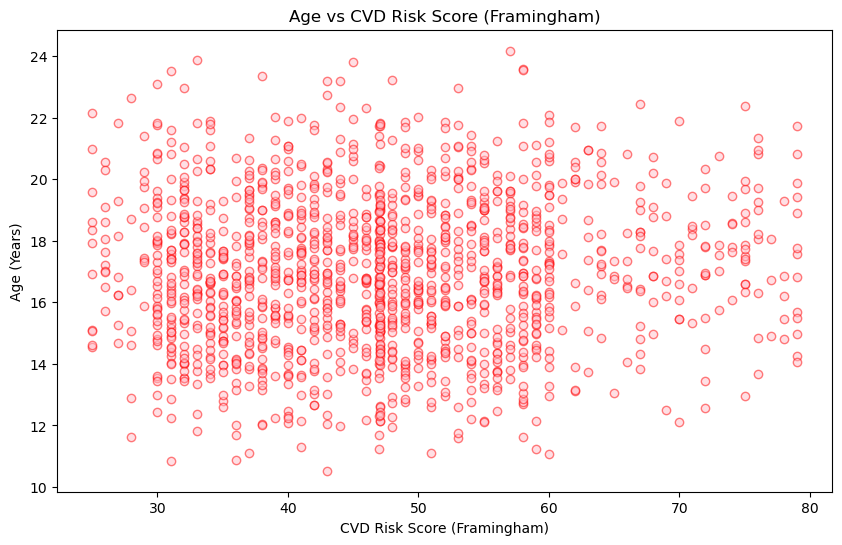

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df["Age"], df["CVD Risk Score"], alpha=0.5, color="pink", edgecolors="red")
plt.xlabel("CVD Risk Score (Framingham)")
plt.ylabel("Age (Years)")
plt.title("Age vs CVD Risk Score (Framingham)")
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df[], df["CVD Risk Score"], alpha=0.5, color="pink", edgecolors="red")
plt.xlabel("CVD Risk Score (Framingham)")
plt.ylabel("Age (Years)")
plt.title("Age vs CVD Risk Score (Framingham)")
plt.show()

### Empirical 

In [123]:
statistic, pvalue = stats.ttest_ind(
    has_diabetes["CVD Risk Score"].dropna(), no_diabetes["CVD Risk Score"].dropna()
)

print("T-statistic:", statistic)
print(f"P-value is {pvalue:.5f}")

T-statistic: 19.356519533425136
P-value is 0.00000


In [ ]:
df_clean = df[["Age", "CVD Risk Score"]].dropna()

slope, intercept, r_value, p_value, std_err = linregress(
    df_clean["Age"], df_clean["CVD Risk Score"]
)

r_squared = r_value**2
print(f"R-squared: {r_squared:.4f}")

print(std_err)

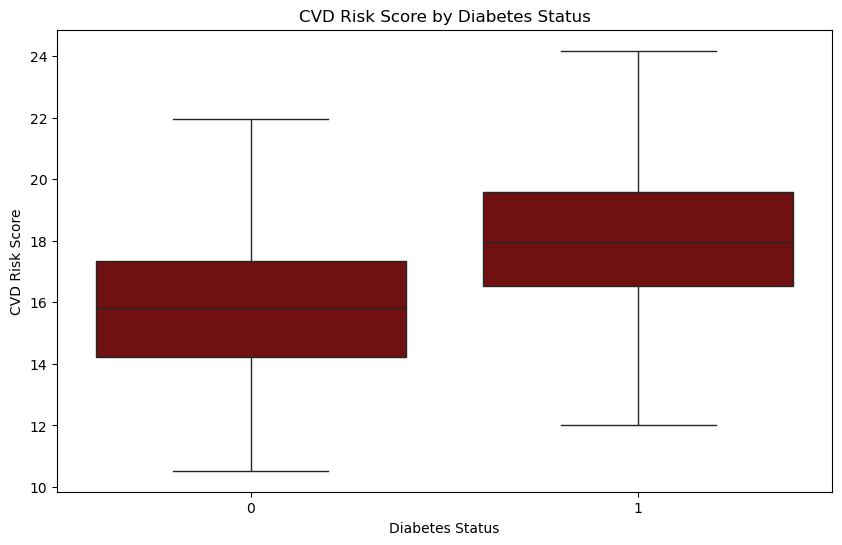

In [124]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Diabetes Status", y="CVD Risk Score", data=df, color="maroon")
plt.xlabel("Diabetes Status")
plt.ylabel("CVD Risk Score")
plt.title("CVD Risk Score by Diabetes Status")
plt.show()

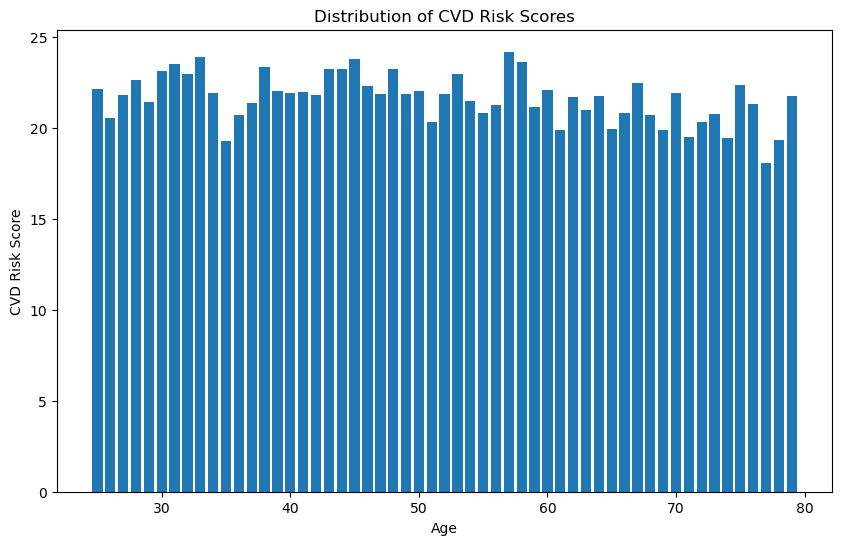

In [125]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.bar(x=df["Age"], height=df["CVD Risk Score"])
plt.xlabel("Age")
plt.ylabel("CVD Risk Score")
plt.title("Distribution of CVD Risk Scores")
plt.show()

In [126]:
df["Age_group"] = pd.cut(
    df["Age"],
    bins=[20, 30, 40, 50, 60, 70, 80],
    labels=["20-30", "30-40", "40-50", "50-60", "60-70", "70-80"],
)

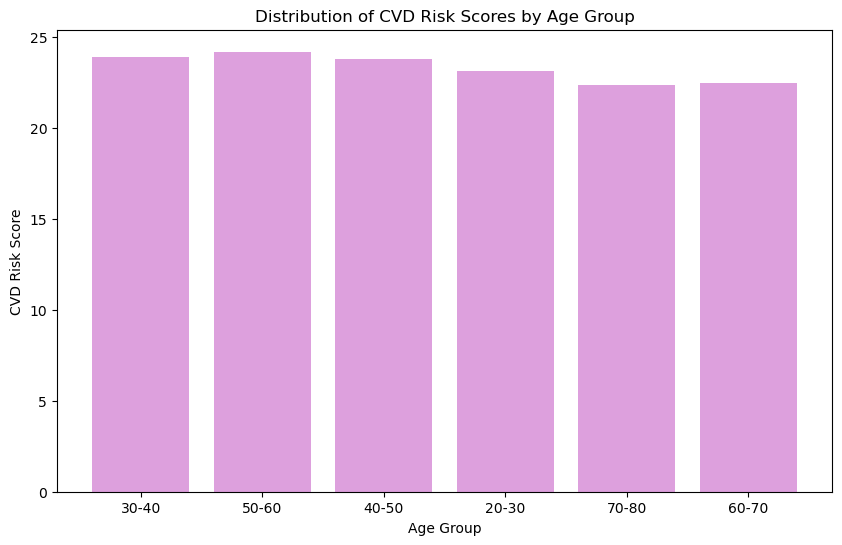

In [127]:
figsize = (10, 6)

plt.figure(figsize=figsize)
plt.bar(x=df["Age_group"], height=df["CVD Risk Score"], color="plum")
plt.xlabel("Age Group")
plt.ylabel("CVD Risk Score")
plt.title("Distribution of CVD Risk Scores by Age Group")
plt.show()

In [136]:
df.head()

,Sex,Age,BMI,Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,Age_group
0,1,32.0000,23.6,248.0,78.0,111.0,0,1,0,0,125.0,79.0,1,140.0,17.93,30-40
1,1,55.0000,41.6,162.0,50.0,135.0,1,1,2,1,139.0,70.0,2,82.0,20.51,50-60
2,0,47.0255,26.9,103.0,73.0,114.0,0,0,2,1,104.0,77.0,0,0.0,12.64,40-50
3,0,44.0000,33.4,134.0,46.0,91.0,0,0,2,1,140.0,83.0,2,58.0,16.36,40-50
4,1,32.0000,28.8,146.0,64.0,141.0,1,1,2,0,144.0,83.0,2,52.0,17.88,30-40


In [ ]:
df["diabetes_status"] = df["Diabetes Status"]
df["cvd_risk_score"] = df["CVD Risk Score"]

In [140]:
model = smf.ols(
    "cvd_risk_score ~ diabetes_status + Age + diabetes_status:Age", data=df
).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         cvd_risk_score   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     127.9
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           1.57e-73
Time:                        12:36:17   Log-Likelihood:                -3198.1
No. Observations:                1459   AIC:                             6404.
Df Residuals:                    1455   BIC:                             6425.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              15.1914    